In [1]:
import os
import cv2
import random
import numpy as np
import glob
from sklearn.model_selection import train_test_split

from PIL import Image as PILImage
from PIL.ExifTags import TAGS

from IPython.display import display

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence

2025-01-25 10:39:16.612391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 10:39:16.632391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 10:39:16.639289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 10:39:16.654523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 10:39:17.487487: W tensorflow/compiler/tf2

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

In [3]:
def imshow(a, size=1.0):
    # Clip and convert the image to uint8
    a = a.clip(0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    
    # Display the image
    display(PILImage.fromarray(a))

In [4]:
def get_label(file_path):
    label = file_path.split("/")[-2]
    label = label.split(".")[-2]
    label = int(label)
    return label

In [5]:
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMAGE_SIZE)
    return img

In [6]:
def generate_triplets(file_paths, labels, num_triplets=10000):
    label_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)
    
    triplets = []
    for _ in range(num_triplets):
        # Select an anchor image and its label
        anchor_idx = random.choice(range(len(file_paths)))
        anchor_label = labels[anchor_idx]

        # Select a positive image (same label)
        positive_idx = random.choice(label_to_indices[anchor_label])
        while positive_idx == anchor_idx:
            positive_idx = random.choice(label_to_indices[anchor_label])

        # Select a negative image (different label)
        negative_label = random.choice([l for l in label_to_indices.keys() if l != anchor_label])
        negative_idx = random.choice(label_to_indices[negative_label])

        triplets.append((file_paths[anchor_idx], file_paths[positive_idx], file_paths[negative_idx]))
    
    return triplets

In [7]:
class DataGenerator(Sequence):
    def __init__(self, triplets, batch_size, image_size, **kwargs):
        super().__init__(**kwargs)
        self.triplets = triplets
        self.batch_size = batch_size
        self.image_size = image_size
      
    def __len__(self):
        return len(self.triplets) // self.batch_size

    def __getitem__(self, index):
        # Get batch of triplets
        batch_triplets = self.triplets[index * self.batch_size : (index + 1) * self.batch_size]
        
        # Prepare arrays for images
        anchors, positives, negatives = [], [], []
        for anchor_path, positive_path, negative_path in batch_triplets:
            # Load and normalize images
            anchors.append(read_image(anchor_path) / 255.0)
            positives.append(read_image(positive_path) / 255.0)
            negatives.append(read_image(negative_path) / 255.0)

        # Convert lists to arrays and return
        anchors = np.array(anchors)
        positives = np.array(positives)
        negatives = np.array(negatives)
        
     
        
        #print(f"Anchors shape: {anchors.shape}, Positives shape: {positives.shape}, Negatives shape: {negatives.shape}")
        return (anchors, positives, negatives), np.zeros((self.batch_size, 1))
        

In [8]:
data_folder = "Data/00*"
image_files = glob.glob(os.path.join(data_folder, "*.jpg"), recursive=True)

labels = [get_label(file_path) for file_path in image_files]

train_x, val_x, train_y, val_y = train_test_split(image_files, labels, test_size=0.2, random_state=42, stratify=labels)   

In [9]:
train_triplets = generate_triplets(train_x, train_y, num_triplets=10000)
val_triplets = generate_triplets(val_x, val_y, num_triplets=2000)

train_gen = DataGenerator(train_triplets, batch_size=BATCH_SIZE, image_size=(256, 256, 3))
val_gen = DataGenerator(val_triplets, batch_size=BATCH_SIZE, image_size=(256, 256, 3))

In [10]:
def build_resnet_embedding_network(input_shape=(256, 256, 3), embedding_dim=128):
    # Load pre-trained ResNet50 without the top layer
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # Freeze the base model's weights (optional, for fine-tuning later)
    base_model.trainable = False
    
    # Add custom layers for embedding extraction
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(embedding_dim, activation='relu'),  # Embedding dimension
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings
    ])
    
    return model

# Create the embedding network
embedding_model = build_resnet_embedding_network()
embedding_model.summary()

I0000 00:00:1737797958.603089   21383 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737797958.653158   21383 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737797958.653345   21383 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737797958.656373   21383 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737797958.656517   21383 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 262,272 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
def build_siamese_model_with_resnet(embedding_model, input_shape=(256, 256, 3)):
    # Inputs for anchor, positive, and negative images
    anchor_input = layers.Input(name="anchor", shape=input_shape)
    positive_input = layers.Input(name="positive", shape=input_shape)
    negative_input = layers.Input(name="negative", shape=input_shape)
    

    # Pass each input through the embedding network
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    embeddings = layers.Lambda(lambda x: tf.concat(x, axis=1))(
        [anchor_embedding, positive_embedding, negative_embedding]
    )
    
    # Combine embeddings into a Siamese model
    siamese_model = models.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=embeddings
    )

    return siamese_model

siamese_model = build_siamese_model_with_resnet(embedding_model)
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │ 23,849,984 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 384)       │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0], │
│                     │                   │            │ sequential[2][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 262,272 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
def triplet_loss(y_true, y_pred, margin=0.2):
    # Split y_pred into anchor, positive, and negative
    anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
    
    # # Compute distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)  # L2 distance
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    

    # # Compute triplet loss
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)

In [13]:
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

def inspect_outputs(epoch, logs):
    # Fetch the first batch of data from the generator
    inputs, _ = train_gen[0]
    
    # Get model predictions for the batch
    pred = siamese_model.predict(inputs, verbose=0)
    
    anchors = pred[:, :128]
    positives = pred[:, 128:256]
    negatives = pred[:, 256:]
    
    # Print the embeddings for debugging
    print(f"Epoch {epoch + 1}:")
    print(f"Anchor embedding sample: {anchors[0]}")
    print(f"Positive embedding sample: {positives[0]}")
    print(f"Negative embedding sample: {negatives[0]}")

output_inspector = LambdaCallback(on_epoch_end=inspect_outputs)

In [14]:
siamese_model.compile(optimizer='adam', loss=triplet_loss)

# Train the model
siamese_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10


/home/marroj/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['anchor', 'positive', 'negative']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1737797974.887043   21481 service.cc:146] XLA service 0x7f1a6404ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737797974.887090   21481 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-01-25 10:39:35.440196: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-25 10:39:37.737485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1737797984.512039   21481 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once

312/312 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - loss: 0.1731 - val_loss: 0.1708
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 304s 973ms/step - loss: 0.1565 - val_loss: 0.1853
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.1518 - val_loss: 0.1735
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 0.1494 - val_loss: 0.2328
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 296s 948ms/step - loss: 0.1412 - val_loss: 0.1751
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - loss: 0.1359 - val_loss: 0.1960
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - loss: 0.1358 - val_loss: 0.1788
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - loss: 0.1321 - val_loss: 0.1842
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 310s 993ms/step - loss: 0.1262 - val_loss: 0.1890
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - loss: 0.1282 - val_loss: 0.1852


In [15]:
siamese_model.save("siamese_resnet_model.h5")

In [16]:
embedding_model.save("embedding_resnet_model.h5")

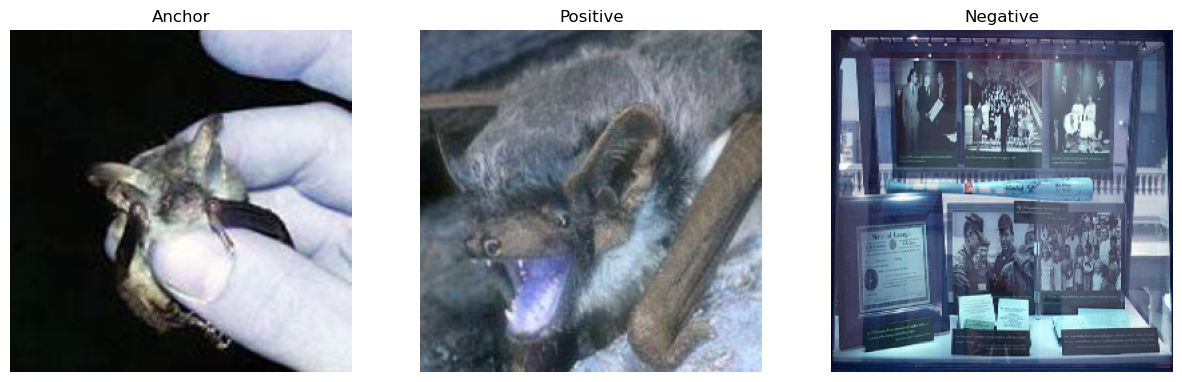

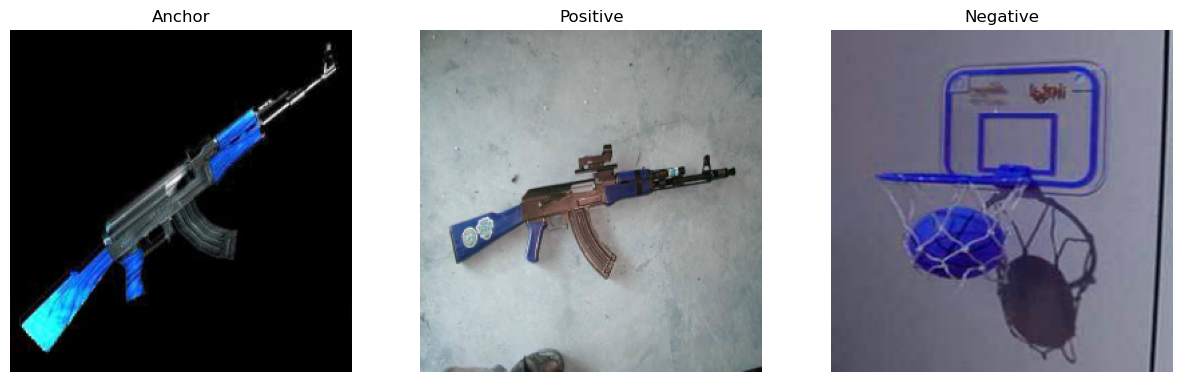

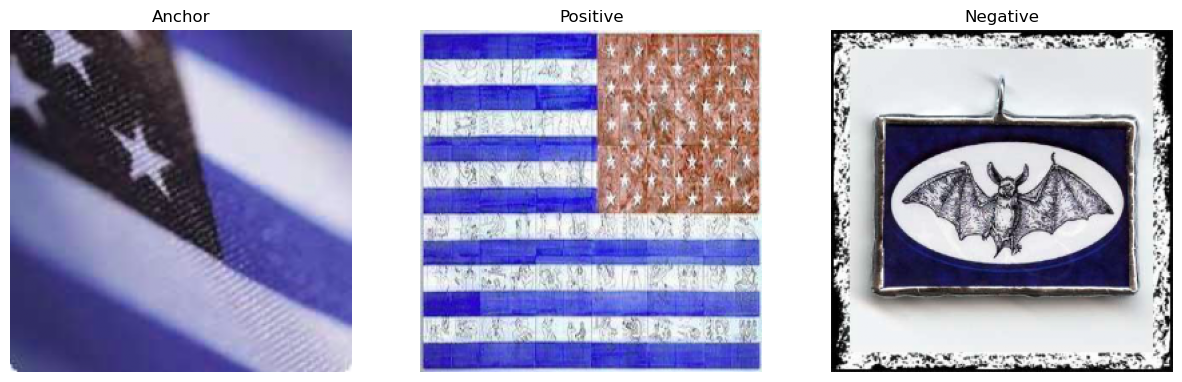

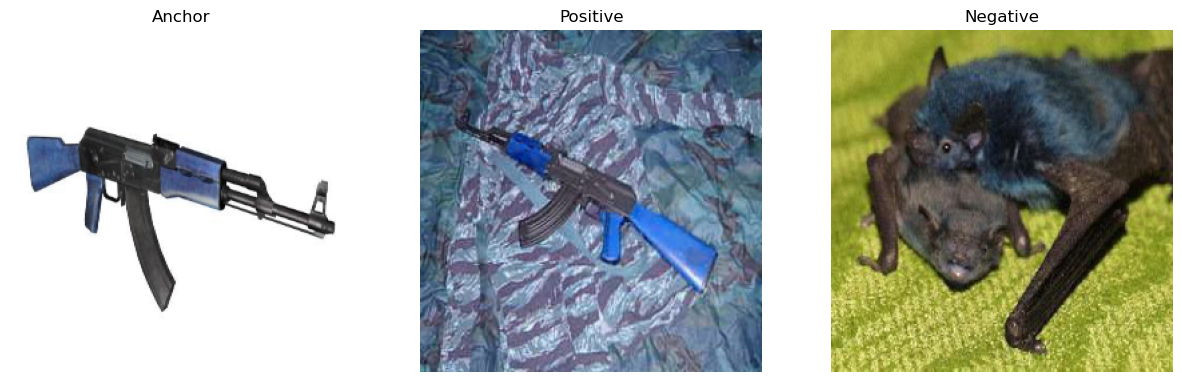

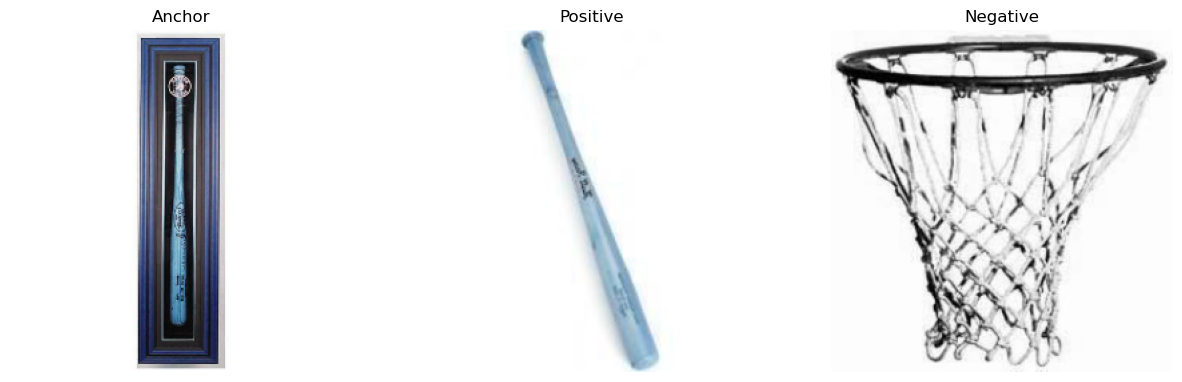

In [19]:
import matplotlib.pyplot as plt

for i in range(5):
    inputs, _ = train_gen[i]
    anchors, positives, negatives = inputs
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Show anchor
    axes[0].imshow(anchors[0])
    axes[0].set_title("Anchor")
    axes[0].axis('off')

    # Show positive
    axes[1].imshow(positives[0])
    axes[1].set_title("Positive")
    axes[1].axis('off')

    # Show negative
    axes[2].imshow(negatives[0])
    axes[2].set_title("Negative")
    axes[2].axis('off')

    plt.show()
    